# Final Capstone Notebook 3 out of 4

The goal of phase 2 is to use the sentiment classifier we created in phase 1 to analyze and integrate unlabeled datasets. We want to display the distribution of positive and negative reviews for the unlabeled source. In our demo on notebook 4, we will also be able to show reviews over time. Once, we analyze the data, we will combine our new dataset into our existing labelled dataset. 

The benefit is that if we are presented with more unlabeled datasets in the future, we can run phase 2 and integrate them into our dataset. Businesses with a limited yelp presence can still get insight if they have data from other sources such as Facebook comments and Twitter tweets. As long as the data can be provided in a table format (one review per row), we can clean it, analyze it, and integrate it.

The goal of phase 3 is to extract topics from negative and positive reviews. If we can extract these topics, it will be able to give restaurant owners key insights into what they can improve on and how certain facets of their business compare to other restaurants in their area. To do this, we will first apply a topic extraction model to all the restaurants and determine the loadings for the industry in Cleveland, Ohio. In our demo, we will then use this same extraction model on a filtered review list specific to a particular restaurant. We will then compare the loadings for each. Phase 3 was roughly inspired by a [github](https://github.com/Vishwacorp/yelp_nlp) by Ankur Vishwakarma. Although the general idea is similar, our execution, topics, and conclusion will be different.  

In [1]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

# Code to load model from Google Drive:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

# Basic libraries
import numpy as np
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load 
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style="whitegrid")

# Supervised learning models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Deep neutral networks
import tensorflow as tf
'''

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
'''

# Text manipulation tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from wordcloud import WordCloud

# Remove column width so we can read entire text
pd.set_option('display.max_colwidth', 0)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset and Models

We will handle the dataset the same way that we handled it in notebook 2.

In [0]:
# Pull from Google Drive
downloaded = gdrive.CreateFile({'id':'1jgK8n9-vHNgtU-JHiNN-vkhGJgkcpulR'})
downloaded.GetContentFile('yelp_reviews_lem.csv') 

downloaded = gdrive.CreateFile({'id':'1ZQJ3NSHEy4QARk2XN_sSYTk0FiJqfIE_'})
downloaded.GetContentFile('yelp_tips_lem.csv')

# Read files as df
df = pd.read_csv('yelp_reviews_lem.csv') 
tips = pd.read_csv('yelp_tips_lem.csv')

# Add target variable
df['target'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

# Remove nulls
df.dropna(inplace=True)
tips.dropna(inplace=True)

In [3]:
df.head(2)

,business_id,stars,date,text,useful,funny,cool,name,review_count,lem_join,target
0,meXjqyhTNLFmknY39y2sMg,5,2014-09-11,"Solid beers -- Christmas Ale defines my holiday season. I moved away a long time ago, but whenever I am home, I try to make a stop at Great Lakes. Great vibe, super chill, stellar food and beer.",1,1,1,"""Great Lakes Brewing Company""",751,solid beer christmas ale define holiday season away long time ago home try stop great lakes great vibe super chill stellar food beer,1
1,meXjqyhTNLFmknY39y2sMg,3,2013-10-13,"Meh. It was OK. A bartender the night before somewhere told us that while we were in Cleveland we HAD to eat here, so we took her advice and grabbed an early dinner here after spending the day at the Rock N Roll Hall of Fame. Like I said, it was alright. We had 3 different servers through the meal (dont know what ANY of their names were, and was never told that someone else would be taking care of us... all the sudden, someone else just started coming to our table). The first server suggested the pizza because it was half off, so we both had one.. they were decent, but not something that I think I would have suggested to anyone, and definitely not something I would order again. Not that they were BAD, but I think (or I hope..) they have better choices. We originally ordered a beer flight of all 6 specialty beers, and I didn't like any of them (not because they weren't good beers, I'm sure they were, but for someone who isn't a big beer drinker- it was a no go), so my husband just drank all of them, and when I ordered a soda, our SECOND server laughed at me. 'Nuff said, I think. Anyway, it was an experience, and we both like trying new places, especially local spots, so I'm glad we went. It just wasn't the amazing time we were expecting based on what we had been told. And to be fair, maybe all of that isn't normal- sometimes things happen and you just draw the short straw. But we weren't super impressed.\n\nGood gift shop, though. They sell most of the specialty beers in the shop and you can make your own six packs of whatever you want. Plus they have some nice merchandise to choose from, too.",0,1,0,"""Great Lakes Brewing Company""",751,meh ok bartender night tell cleveland eat advice grab early dinner spend day rock n roll hall fame like alright 3 different server meal do not know never tell else care sudden else start come table server suggest pizza half decent not think suggest definitely not order not bad think hope well choice originally order beer flight 6 specialty beer do not like not not good beer sure not big beer drinker- no go husband drink order soda second server laugh nuff think experience like try new place especially local spot glad go not amazing time expect base tell fair maybe not normal- thing happen draw short straw not super impressed \n\n good gift shop sell specialty beer shop pack want plus nice merchandise choose,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56906 entries, 0 to 56909
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   business_id   56906 non-null  object
 1   stars         56906 non-null  int64 
 2   date          56906 non-null  object
 3   text          56906 non-null  object
 4   useful        56906 non-null  int64 
 5   funny         56906 non-null  int64 
 6   cool          56906 non-null  int64 
 7   name          56906 non-null  object
 8   review_count  56906 non-null  int64 
 9   lem_join      56906 non-null  object
 10  target        56906 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 5.2+ MB


In [5]:
tips.head()

,text,date,likes,business_id,lem_join,name
0,"The Cleveland Pickle is the best sandwich deli ever! Hands down! Unique, fresh, delicious, creative! Amazing! Can't wait to go back!",2012-10-20,0,MTsIckdo3_uKuqk3B4zuKA,cleveland pickle good sandwich deli hand unique fresh delicious creative amazing not wait go,"""Cleveland Pickle"""
1,A bit different. Out at a restaurant for Thanksgiving. Buffet looks yummy.,2010-11-25,0,0youcKV6-eE3F2MQj1l6Fw,bit different restaurant thanksgiving buffet look yummy,"""100th Bomb Group"""
2,Tab Benoit,2012-08-10,0,CDqPVVvQtVncNQGydnZy7A,tab benoit,"""Beachland Ballroom and Tavern"""
3,One of the. Eat buffet I have been to in an very long time,2016-10-28,0,pGjtxXBq4tZcdKdgTU-Tww,eat buffet long time,"""Little Hong Kong"""
4,Shipwreck! That's an awesome breakfast!,2010-09-11,0,_5PJ4GHIXNdUdXtohylKGQ,shipwreck awesome breakfast,"""Lucky's Café"""


In [6]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10082 entries, 0 to 10106
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         10082 non-null  object
 1   date         10082 non-null  object
 2   likes        10082 non-null  int64 
 3   business_id  10082 non-null  object
 4   lem_join     10082 non-null  object
 5   name         10082 non-null  object
dtypes: int64(1), object(5)
memory usage: 551.4+ KB


In [0]:
# load models from Google Drive
path = '/content/gdrive/My Drive/Final_Capstone/'

with open(path + 'lrm_model.pkl', 'rb') as f:
    lrm = pickle.loads(f.read())   

keras = tf.keras.models.load_model(path + 'keras_model.tf')

# Phase 2: Analysis/integration of unlabeled text (yelp tips)

Now that we have our two trained models, let's see how they handle unlabelled sentences. We will use yelp tips to demonstrate proof of concept. Ideally, if this model is effective, we can use it to calculate sentiment for different media platforms such as Facebook comments, twitter tweets, etc.

Since the sentences are unlabelled, the hard part will be verifying how effective our model is. When we look at the predictions of KERAS and logistic regression, we will see where they disagree to determine if there are any systematic errors.

In [8]:
# train vectorizer
tfidf_vec = TfidfVectorizer(
    max_df=0.5, 
    min_df=2,
    stop_words='english', 
    lowercase=True,
    use_idf=True,
    norm=u'l2',
    smooth_idf=True, 
    ngram_range = (1,2)
)

X = df['lem_join']
Y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y
)

tfidf_vec.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=None,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [9]:
# Predict using KERAS and logistic regression models
tips_tfidf = tfidf_vec.transform(tips['lem_join'])
tips['pred_lrm'] = lrm.predict_proba(tips_tfidf)[:, 1]
tips['pred_keras'] = keras.predict_proba(tips_tfidf.sorted_indices())

tips['lrm_round'] = tips['pred_lrm'].round()
tips['keras_round'] = tips['pred_keras'].round()

# Delete models to save memory
del lrm
del keras

tips.head()

Instructions for updating:
Please use `model.predict()` instead.


,text,date,likes,business_id,lem_join,name,pred_lrm,pred_keras,lrm_round,keras_round
0,"The Cleveland Pickle is the best sandwich deli ever! Hands down! Unique, fresh, delicious, creative! Amazing! Can't wait to go back!",2012-10-20,0,MTsIckdo3_uKuqk3B4zuKA,cleveland pickle good sandwich deli hand unique fresh delicious creative amazing not wait go,"""Cleveland Pickle""",0.999102,0.999998,1.0,1.0
1,A bit different. Out at a restaurant for Thanksgiving. Buffet looks yummy.,2010-11-25,0,0youcKV6-eE3F2MQj1l6Fw,bit different restaurant thanksgiving buffet look yummy,"""100th Bomb Group""",0.816541,0.952829,1.0,1.0
2,Tab Benoit,2012-08-10,0,CDqPVVvQtVncNQGydnZy7A,tab benoit,"""Beachland Ballroom and Tavern""",0.412116,0.402963,0.0,0.0
3,One of the. Eat buffet I have been to in an very long time,2016-10-28,0,pGjtxXBq4tZcdKdgTU-Tww,eat buffet long time,"""Little Hong Kong""",0.830811,0.992326,1.0,1.0
4,Shipwreck! That's an awesome breakfast!,2010-09-11,0,_5PJ4GHIXNdUdXtohylKGQ,shipwreck awesome breakfast,"""Lucky's Café""",0.977073,0.999778,1.0,1.0


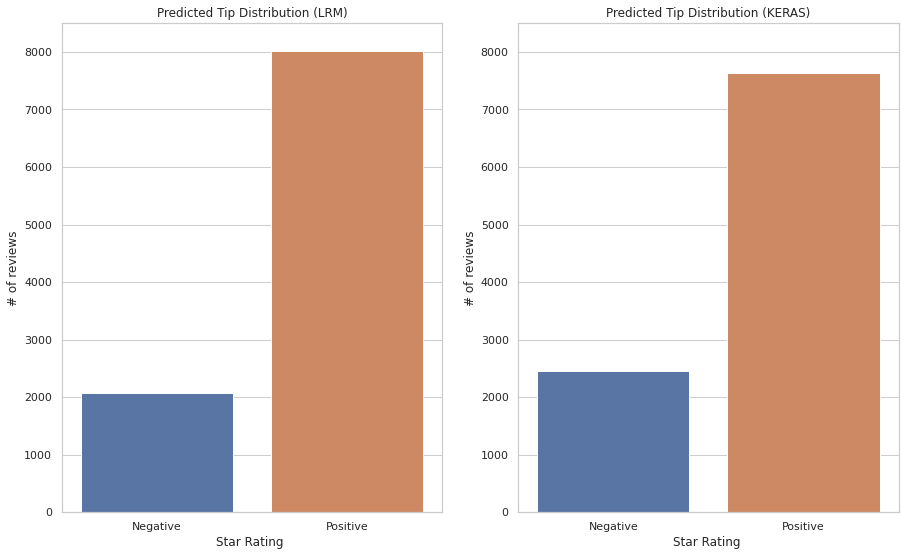

In [10]:
plt.figure(figsize=(15,9))
plt.subplot(1,2,1)
sns.countplot(x='lrm_round', data=tips)
plt.ylabel('# of reviews')
plt.xlabel('Star Rating ')
plt.ylim(0,8500)
plt.xticks([0, 1], ['Negative', 'Positive']) 
plt.title("Predicted Tip Distribution (LRM)")

plt.subplot(1,2,2)
sns.countplot(x='keras_round', data=tips)
plt.ylabel('# of reviews')
plt.xlabel('Star Rating ')
plt.ylim(0,8500)
plt.xticks([0, 1], ['Negative', 'Positive']) 
plt.title("Predicted Tip Distribution (KERAS)");

We can see that even with tips the positive classified tips outweigth the negative ones. We should look into how they differ and match.

In [11]:
# Let's see where the models agree
tips[(tips.lrm_round == tips.keras_round)]

,text,date,likes,business_id,lem_join,name,pred_lrm,pred_keras,lrm_round,keras_round
0,"The Cleveland Pickle is the best sandwich deli ever! Hands down! Unique, fresh, delicious, creative! Amazing! Can't wait to go back!",2012-10-20,0,MTsIckdo3_uKuqk3B4zuKA,cleveland pickle good sandwich deli hand unique fresh delicious creative amazing not wait go,"""Cleveland Pickle""",0.999102,0.999998,1.0,1.0
1,A bit different. Out at a restaurant for Thanksgiving. Buffet looks yummy.,2010-11-25,0,0youcKV6-eE3F2MQj1l6Fw,bit different restaurant thanksgiving buffet look yummy,"""100th Bomb Group""",0.816541,0.952829,1.0,1.0
2,Tab Benoit,2012-08-10,0,CDqPVVvQtVncNQGydnZy7A,tab benoit,"""Beachland Ballroom and Tavern""",0.412116,0.402963,0.0,0.0
3,One of the. Eat buffet I have been to in an very long time,2016-10-28,0,pGjtxXBq4tZcdKdgTU-Tww,eat buffet long time,"""Little Hong Kong""",0.830811,0.992326,1.0,1.0
4,Shipwreck! That's an awesome breakfast!,2010-09-11,0,_5PJ4GHIXNdUdXtohylKGQ,shipwreck awesome breakfast,"""Lucky's Café""",0.977073,0.999778,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
10101,Laughed when I asked to sit next to window?,2017-10-15,0,bK5nWi1oNs63utSlzmRUNg,laugh ask sit window,"""Xinji Noodle Bar""",0.760890,0.992287,1.0,1.0
10102,I've been craving spicy miso udon ever since my first\/last visit!,2017-10-28,0,bK5nWi1oNs63utSlzmRUNg,crave spicy miso udon first\/last visit,"""Xinji Noodle Bar""",0.807494,0.991088,1.0,1.0
10103,amazing thank your,2017-09-24,0,9tqtjCPLBs_WSC7T9p6ruQ,amazing thank,"""Project: Pizza""",0.998970,0.999920,1.0,1.0
10105,Great healthy choices and burgers!,2017-10-30,0,ddm_Rh5WzzuX6Sx7aJ3kwg,great healthy choice burger,"""Hecks Express Coffee + Kitchen""",0.947549,0.999502,1.0,1.0


In [12]:
# Let's see where the models disgree
tips[(tips.lrm_round != tips.keras_round)]

,text,date,likes,business_id,lem_join,name,pred_lrm,pred_keras,lrm_round,keras_round
21,Spring hours Wed-Sat 11:30a-11:00p,2012-07-18,0,QUjJmpTQvGus8WfYq1dtOw,spring hour wed sat 11:30a-11:00p,"""Battiste & Dupree Cajun Grill""",0.398505,0.984224,0.0,1.0
23,Caramel sea salt hot chocolate was tasty. Southwestern chicken salad was unexciting.,2012-04-19,0,OyhCNhJJuJjUt2avxI5POg,caramel sea salt hot chocolate tasty southwestern chicken salad unexcite,"""Chocolate Bar""",0.773269,0.328777,1.0,0.0
25,Saturday brunch!,2014-08-07,0,yTv4ptghx8xrErx6dcW3HA,saturday brunch,"""Toast""",0.847404,0.380879,1.0,0.0
44,"A friend started me on a breakfast item that's not on the menu, the veggie scramble. It's like a veggie omelette but with scrambled eggs. Excellent and even better with cheese.",2016-04-23,0,LnkkArYSmU9pYRWOO6oPzw,friend start breakfast item not menu veggie scramble like veggie omelette scramble egg excellent better cheese,"""Yours Truly Restaurants""",0.772602,0.161101,1.0,0.0
52,Try the Deviled Eggs!!!,2014-07-23,0,RiGtSzVzc42CKjyZkDxZRA,try devil eggs,"""Crop Bistro & Bar""",0.782756,0.237191,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
10053,Above average drinks. Good pastries. Clean atmosphere. Layout is nice.,2017-04-03,0,IBTbSC9zAodn54NuuphLhQ,average drink good pastry clean atmosphere layout nice,"""Fluffy Duck Cafe""",0.233649,0.603406,0.0,1.0
10054,My vote for best croissant in he U.S. Certainly and good as anything we have in NYC,2017-08-28,0,IBTbSC9zAodn54NuuphLhQ,vote good croissant u.s. certainly good nyc,"""Fluffy Duck Cafe""",0.406096,0.734867,0.0,1.0
10082,Great place to grab a burger for lunch. Will be back!,2017-07-14,0,VGRn5KgYKMkqdIKtBUzQQA,great place grab burger lunch will,"""Wahlburgers""",0.820137,0.129601,1.0,0.0
10095,You have to go and try it for yourself!,2017-11-04,0,Jd9L7pNhC982XeCNbPncXg,go try,"""Saucy Brew Works""",0.904105,0.023312,1.0,0.0


It seems that the models disagree when the sentences do not express sentiment at all (i.e. explaining hours or talking about features). Also, we see that the models disagree when the sentence has a combination of negative and positive sentiment. 

We do see that the models disagree erroneously. Some sentences are clearly negative but one of the models thinks it's positive and vice versa. That being said, it doesn't seem to happen a lot. We have 948 rows that disagree, but we have 8,971 rows that do agree. For our analysis, we will only use sentences that both models agree on.

In [13]:
# Let's only use reviews where both models match in prediction
col = ['business_id', 'lem_join', 'text', 'target', 
       'text_type', 'date', 'name']
mask = (tips.lrm_round == tips.keras_round)
tips['target'] = tips['lrm_round']

# Let's label reviews and tips
df['text_type'] = 'yelp_review'
tips['text_type'] = 'yelp_tip'

# Integrate the tips into the reviews dataset
reviews_only = df[col].copy()
tips_only = tips[mask][col].copy()

comb_df = pd.concat([reviews_only, tips_only], ignore_index=True)
comb_df.head(2)

,business_id,lem_join,text,target,text_type,date,name
0,meXjqyhTNLFmknY39y2sMg,solid beer christmas ale define holiday season away long time ago home try stop great lakes great vibe super chill stellar food beer,"Solid beers -- Christmas Ale defines my holiday season. I moved away a long time ago, but whenever I am home, I try to make a stop at Great Lakes. Great vibe, super chill, stellar food and beer.",1.0,yelp_review,2014-09-11,"""Great Lakes Brewing Company"""
1,meXjqyhTNLFmknY39y2sMg,meh ok bartender night tell cleveland eat advice grab early dinner spend day rock n roll hall fame like alright 3 different server meal do not know never tell else care sudden else start come table server suggest pizza half decent not think suggest definitely not order not bad think hope well choice originally order beer flight 6 specialty beer do not like not not good beer sure not big beer drinker- no go husband drink order soda second server laugh nuff think experience like try new place especially local spot glad go not amazing time expect base tell fair maybe not normal- thing happen draw short straw not super impressed \n\n good gift shop sell specialty beer shop pack want plus nice merchandise choose,"Meh. It was OK. A bartender the night before somewhere told us that while we were in Cleveland we HAD to eat here, so we took her advice and grabbed an early dinner here after spending the day at the Rock N Roll Hall of Fame. Like I said, it was alright. We had 3 different servers through the meal (dont know what ANY of their names were, and was never told that someone else would be taking care of us... all the sudden, someone else just started coming to our table). The first server suggested the pizza because it was half off, so we both had one.. they were decent, but not something that I think I would have suggested to anyone, and definitely not something I would order again. Not that they were BAD, but I think (or I hope..) they have better choices. We originally ordered a beer flight of all 6 specialty beers, and I didn't like any of them (not because they weren't good beers, I'm sure they were, but for someone who isn't a big beer drinker- it was a no go), so my husband just drank all of them, and when I ordered a soda, our SECOND server laughed at me. 'Nuff said, I think. Anyway, it was an experience, and we both like trying new places, especially local spots, so I'm glad we went. It just wasn't the amazing time we were expecting based on what we had been told. And to be fair, maybe all of that isn't normal- sometimes things happen and you just draw the short straw. But we weren't super impressed.\n\nGood gift shop, though. They sell most of the specialty beers in the shop and you can make your own six packs of whatever you want. Plus they have some nice merchandise to choose from, too.",0.0,yelp_review,2013-10-13,"""Great Lakes Brewing Company"""


In [0]:
# export data to Google Drive
comb_df.to_csv("comb_df.csv")
uploaded = gdrive.CreateFile({'title': 'comb_df.csv'})
uploaded.SetContentFile("comb_df.csv")
uploaded.Upload()

# Phase 3: Choosing topic extraction model

We will run LSA, LDA, and NNMF using Tf-idf. For NNMF, we will also run BoW as it has shown promise in the past. We will display the top weighted words for each model to give us an rough idea of how the model is clustering the topics. 

In [0]:
# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic = tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    comp_df=pd.DataFrame(words_by_topic,index=wordlist)

    return comp_df

In [0]:
# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    
    list_df = []
    
    # Go through each component
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords = components.iloc[:,column].sort_values(ascending=False)
        
        # Choose the N highest loadings.
        chosen = sortedwords[:n_top_words].to_frame()
        
        # Format df
        chosen.rename(columns={column: 'Topic {}'.format(column)}, inplace=True)
        chosen = chosen.round(2) 
        
        # Add to list of dataframes
        list_df.append(chosen)

    return list_df

In [0]:
from IPython.core.display import HTML
# Displays dataframes side by side for easy reading
def display_side_by_side(table_list):
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

## Divide the data and process it

In [0]:
neg_text = comb_df[comb_df.target == 0].lem_join
pos_text = comb_df[comb_df.target == 1].lem_join

## Prep Tf-Idf

Since we already have the labels for the reviews, we can remove negative words like "no" as well as sentiment related words like "good". Since we had used exceptions to omit certain words from the original stopwords, we need to be sure that we omit these words going forward. For topic extraction, let's include bigrams and trigrams to see if we get additional insight.

In [0]:
# Since most stop words were removed, we only have to add a few words
addwords = ['like', 'tell', 'ok', 'come', 'good', 'do', 'no', 
            'not', 'never', 'nothing', 'none', 'go', 'else', 
            'elsewhere', 'well',
            ]

params = {'max_df': 0.5, 
          'min_df': 2, 
          'stop_words': addwords,
          'lowercase': True, 
          'use_idf': True, 
          'norm': u'l2', 
          'smooth_idf': True, 
          'ngram_range': (1,3)
          }

In [0]:
# Define vectorizers
tfidf_pos = TfidfVectorizer(**params)
tfidf_neg = TfidfVectorizer(**params)

# Transform negative reviews and get word list
neg_tfidf = tfidf_pos.fit_transform(neg_text)
neg_tfidf_terms = tfidf_pos.get_feature_names()

# Transform positive reviews and get word list
pos_tfidf = tfidf_neg.fit_transform(pos_text)
pos_tfidf_terms = tfidf_neg.get_feature_names()

## Determine number of topics
We will make an SVD scree plot to determine the number of topics (eigencomponents). Based on the plot below we can see the elbow occurs at 5 for positive reviews and 7 for negative reviews. Let's average them out and use 6 topics.

In [0]:
# set the n_components to 20
params = {'n_components': 20,
          'n_iter': 7,
          'random_state': 42,
          }

svd_neg = TruncatedSVD(**params)
svd_pos = TruncatedSVD(**params)

svd_neg.fit_transform(neg_tfidf)
sin_val_neg = svd_neg.singular_values_

svd_pos.fit_transform(pos_tfidf)
sin_val_pos = svd_pos.singular_values_

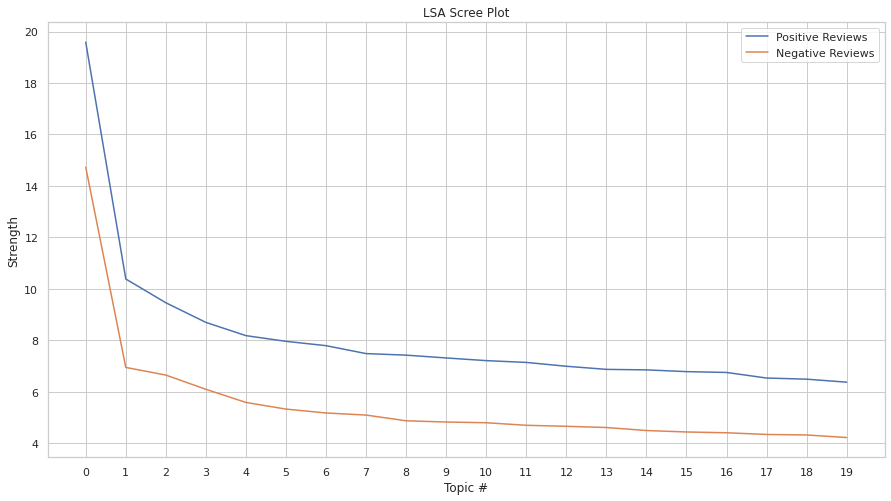

In [22]:
plt.figure(figsize=(15,8))
plt.plot(range(20), sin_val_pos, label='Positive Reviews')
plt.plot(range(20), sin_val_neg, label='Negative Reviews')
plt.xticks(range(20))
plt.xlabel('Topic #')
plt.ylabel('Strength')
plt.title('LSA Scree Plot')
plt.legend();

In [0]:
# Set number of top words
n_top_words = 10

# Set number of topics.
ntopics = 6

## Method 1: LSA topic extraction using tf-idf

In [0]:
params = {'n_components': ntopics, 
          'n_iter': 7,
          'random_state': 42}


svd_neg = TruncatedSVD(**params)
svd_pos = TruncatedSVD(**params)

# Analyze negative reviews
X_svd_neg = svd_neg.fit_transform(neg_tfidf)
comp_svd_neg = word_topic(neg_tfidf, X_svd_neg, neg_tfidf_terms)
svd_results_neg = top_words(comp_svd_neg, n_top_words)

# Analyze positive reviews
X_svd_pos = svd_pos.fit_transform(pos_tfidf)
comp_svd_pos = word_topic(pos_tfidf, X_svd_pos, pos_tfidf_terms)
svd_results_pos = top_words(comp_svd_pos, n_top_words)

In [25]:
print('LSA Top Words (Negative)\n')
display_side_by_side(svd_results_neg)

LSA Top Words (Negative)



,Topic 0
order,47.64
place,41.71
time,34.36
service,33.59
drink,27.62
table,27.44
wait,27.06
restaurant,25.54
great,25.22
minute,23.80


In [26]:
print('LSA Top Words (Positive)\n')
display_side_by_side(svd_results_pos)

LSA Top Words (Positive)



,Topic 0
great,102.60
food,95.43
place,82.82
service,54.60
time,52.84
order,51.24
love,51.20
try,46.48
delicious,45.03
cleveland,43.79


## Method 2a: NMF topic extraction (tf-idf)

In [0]:
params = {'alpha': 0.0, 
          'init': 'nndsvdar',
          'l1_ratio': 0.0, 
          'max_iter': 200, 
          'n_components': ntopics, 
          'random_state': 0, 
          'solver': 'cd', 
          'tol': 0.0001, 
          'verbose': 0}

nmf_neg = NMF(**params)
nmf_pos = NMF(**params)

# Analyze negative reviews
X_nmf_neg = nmf_neg.fit_transform(neg_tfidf) 
comp_nmf_neg = word_topic(neg_tfidf, X_nmf_neg, neg_tfidf_terms)
nmf_results_neg = top_words(comp_nmf_neg, n_top_words)

# Analyze positive reviews
X_nmf_pos = nmf_pos.fit_transform(pos_tfidf) 
comp_nmf_pos = word_topic(pos_tfidf, X_nmf_pos, pos_tfidf_terms)
nmf_results_pos = top_words(comp_nmf_pos, n_top_words)

In [28]:
print('NMF Top Words (Negative)\n')
display_side_by_side(nmf_results_neg)

NMF Top Words (Negative)



,Topic 0
wait,6.96
table,6.50
minute,6.13
drink,5.72
order,5.54
time,5.42
place,4.72
ask,4.71
bar,4.59
service,4.33


In [29]:
print('NMF Top Words (Positive)\n')
display_side_by_side(nmf_results_pos)

NMF Top Words (Positive)



,Topic 0
place,12.72
food,11.22
great,10.70
order,10.39
time,9.77
try,8.80
delicious,8.13
restaurant,7.75
cleveland,7.71
menu,7.21


## Method 2b: NMF topic extraction using BoW

In [0]:
params = {'max_df': 0.5, 
          'min_df': 2, 
          'stop_words': addwords,
          'lowercase': True, 
          'ngram_range': (1,3)
          }

# Define vectorizers
bow_pos = CountVectorizer(**params)
bow_neg = CountVectorizer(**params)

# Transform negative reviews and get word list
neg_bow = bow_pos.fit_transform(neg_text)
neg_bow_terms = bow_pos.get_feature_names()

# Transform positive reviews and get word list
pos_bow = bow_neg.fit_transform(pos_text)
pos_bow_terms = bow_neg.get_feature_names()

In [0]:
params = {'alpha': 0.0, 
          'init': 'nndsvdar',
          'l1_ratio': 0.0, 
          'max_iter': 200, 
          'n_components': ntopics, 
          'random_state': 0, 
          'solver': 'cd', 
          'tol': 0.0001, 
          'verbose': 0}

nmf_neg_bow = NMF(**params)
nmf_pos_bow = NMF(**params)

# Analyze negative reviews
X_nmf_neg_bow = nmf_neg_bow.fit_transform(neg_bow) 
comp_nmf_neg_bow = word_topic(neg_bow, X_nmf_neg_bow, neg_bow_terms)
nmf_results_neg_bow = top_words(comp_nmf_neg_bow, n_top_words)

# Analyze positive reviews
X_nmf_pos_bow = nmf_pos_bow.fit_transform(pos_bow) 
comp_nmf_pos_bow = word_topic(pos_bow, X_nmf_pos_bow, pos_bow_terms)
nmf_results_pos_bow = top_words(comp_nmf_pos_bow, n_top_words)

In [32]:
print('NMF Top Words Using BoW (Negative)\n')
display_side_by_side(nmf_results_neg_bow)

NMF Top Words Using BoW (Negative)



,Topic 0
order,1199.42
table,1192.48
wait,918.12
service,871.18
drink,852.72
minute,843.14
ask,781.94
place,775.35
time,762.74
server,664.95


In [33]:
print('NMF Top Words Using BoW(Positive) \n')
display_side_by_side(nmf_results_pos_bow)

NMF Top Words Using BoW(Positive) 



,Topic 0
order,1878.36
food,1634.35
place,1387.17
great,1292.25
time,1224.30
try,1180.40
restaurant,1136.33
menu,948.56
delicious,931.09
dish,926.82


## Method 3: LDA topic extraction (tf-idf)

In [0]:
params = {'n_components': ntopics, 
          'doc_topic_prior': None,
          'topic_word_prior': 1/ntopics,
          'learning_decay': 0.7,
          'learning_offset': 10.0,
          'max_iter': 0,
          'evaluate_every': -1,
          'mean_change_tol': 0.001,
          'max_doc_update_iter': 100,
          'n_jobs': -1,
          'verbose': 0, 
          'random_state': 0}

lda_neg = LDA(**params)
lda_pos = LDA(**params)

# Analyze negative reviews
X_lda_neg = lda_neg.fit_transform(neg_tfidf) 
comp_lda_neg = word_topic(neg_tfidf, X_lda_neg, neg_tfidf_terms)
lda_results_neg = top_words(comp_lda_neg, n_top_words)

# Analyze positive reviews
X_lda_pos = lda_pos.fit_transform(pos_tfidf) 
comp_lda_pos = word_topic(pos_tfidf, X_lda_pos, pos_tfidf_terms)
lda_results_pos = top_words(comp_lda_pos, n_top_words)

In [35]:
print('LDA Top Words (Negative)\n')
display_side_by_side(lda_results_neg)

LDA Top Words (Negative)



,Topic 0
place,57.73
order,56.05
pizza,53.17
service,50.07
time,43.12
bad,41.88
restaurant,38.33
eat,35.91
great,35.66
drink,33.85


In [36]:
print('LDA Top Words (Positive)\n')
display_side_by_side(lda_results_neg)

LDA Top Words (Positive)



,Topic 0
place,57.73
order,56.05
pizza,53.17
service,50.07
time,43.12
bad,41.88
restaurant,38.33
eat,35.91
great,35.66
drink,33.85


## Comparing extractors by examing sparsity

We want to see how the text extraction methods share words between the topics. If certain words isolate to a certain topic, we can use that as a metric for analyzing keep elements of restaurants. We want to include words that factor time, service, food quality, ambience, and bar experience. 



### Positive Reviews

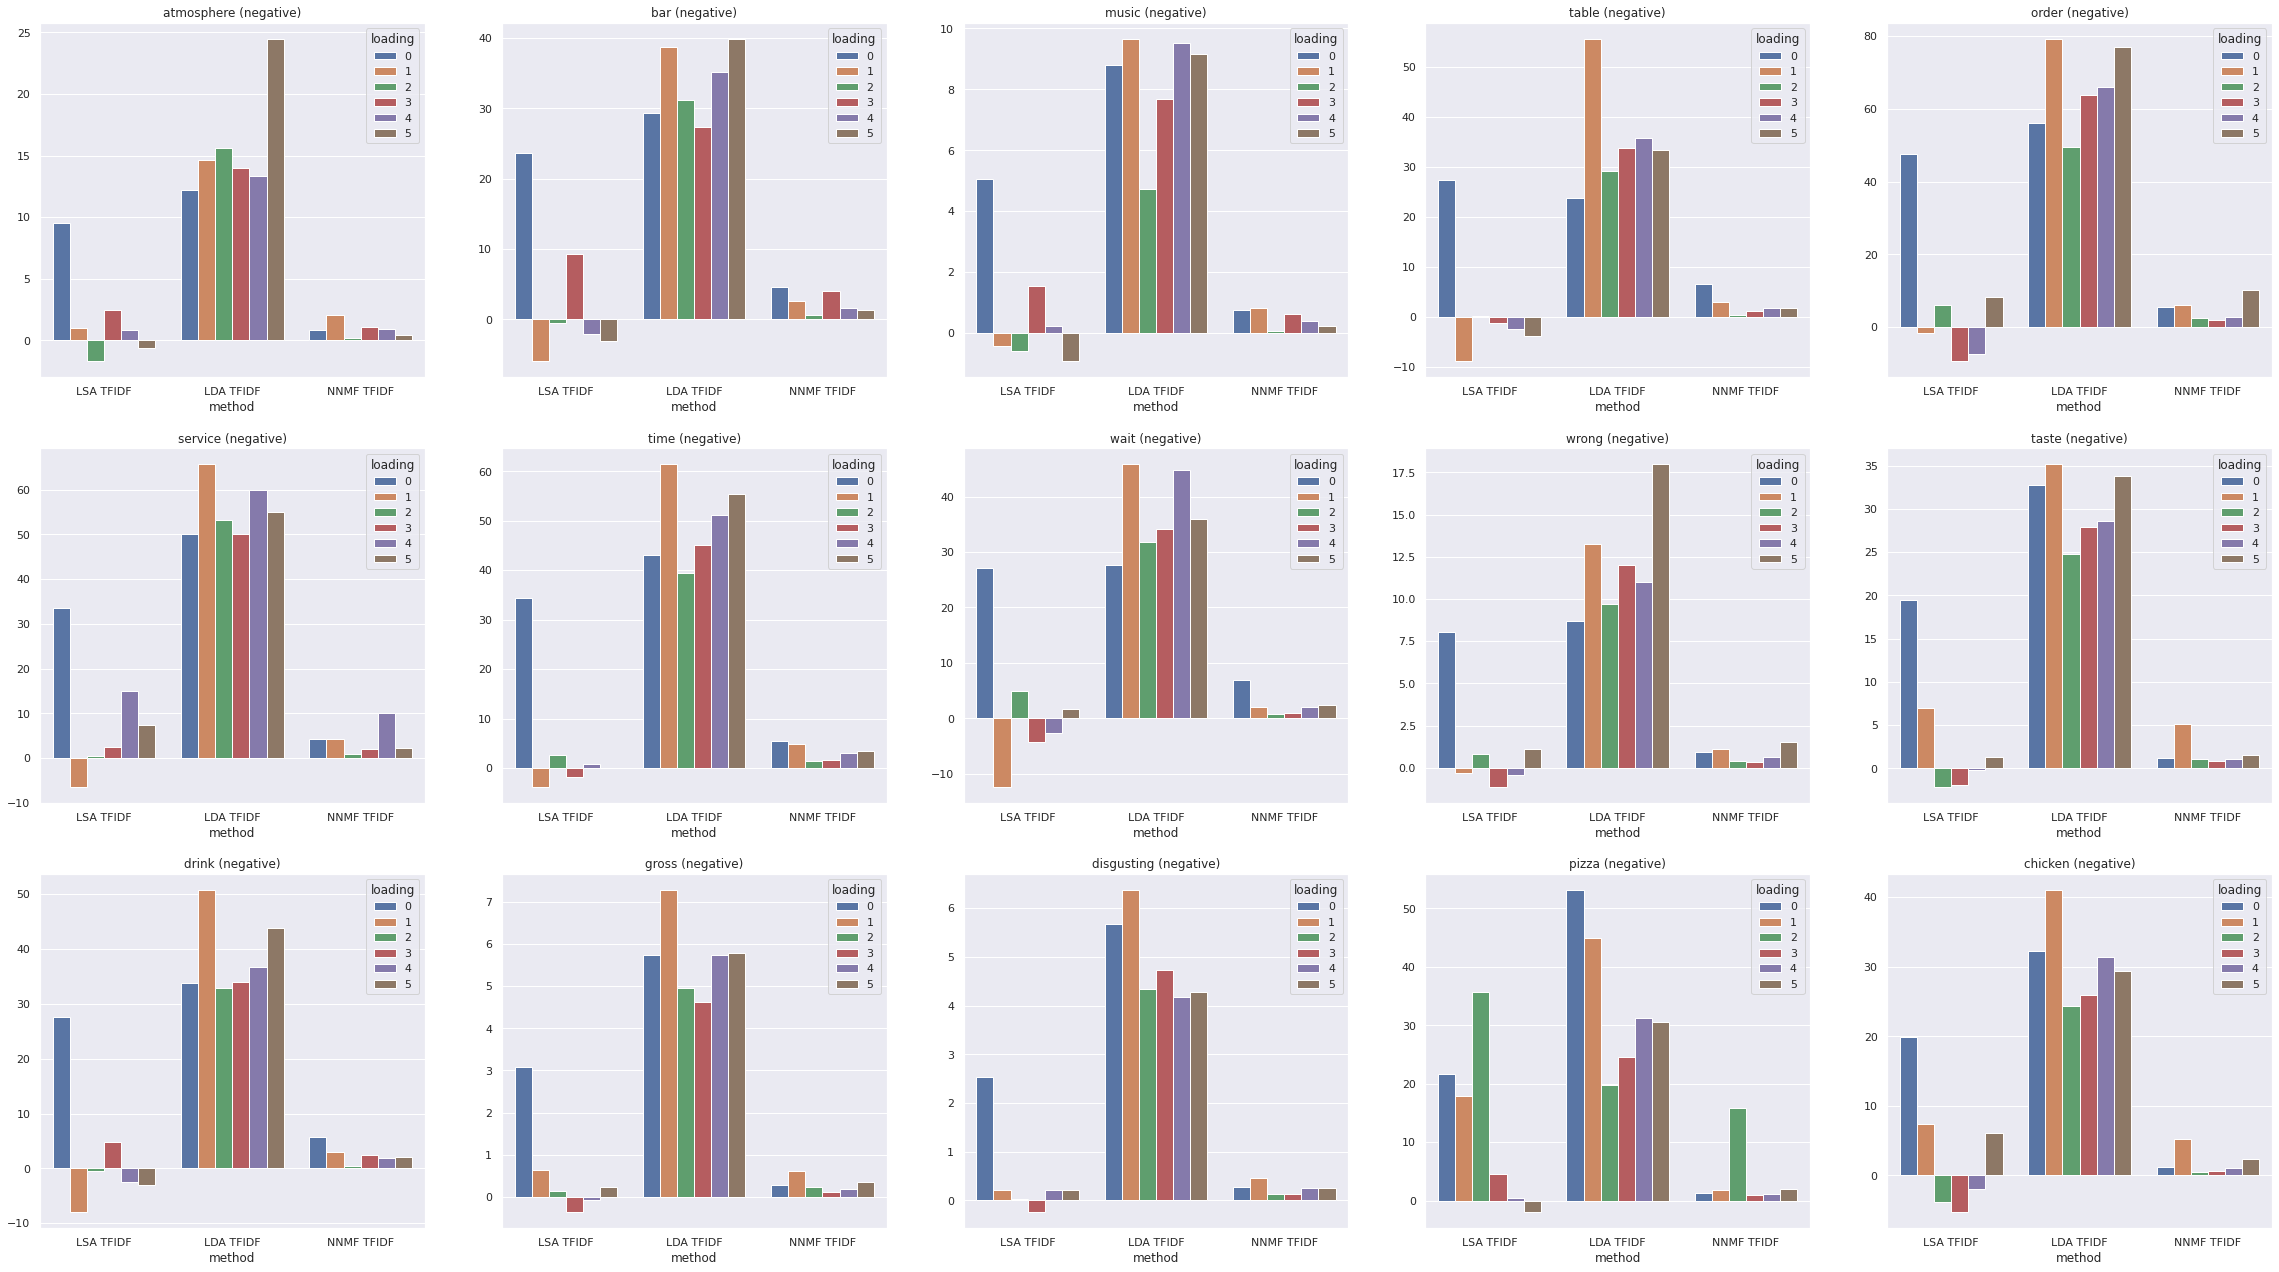

In [37]:
# The words to look at.
targetwords=['atmosphere', 'bar', 'music', 
             'table', 'order', 'service', 
             'time', 'wait', 'wrong', 
             'taste', 'drink', 'gross', 
             'disgusting', 'pizza', 'chicken',
             ]

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=comp_svd_neg.loc[word].append(
        comp_lda_neg.loc[word]).append(
            comp_nmf_neg.loc[word])
                
    wordloadings[word]=loadings

# Labeling the data by method
labels = ['LSA TFIDF','LDA TFIDF','NNMF TFIDF']
wordloadings['method']=np.repeat(labels, ntopics, axis=0)
wordloadings['loading']=list(range(ntopics))*len(labels)

sns.set(style="darkgrid")
plt.figure(figsize=(40, 30))
for i, word in enumerate(targetwords):
    plt.subplot(4, 5, i+1) 
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word + ' (negative)')
    plt.ylabel("")

plt.show()

The LSA method seems to isolate all words except 'pizza' to topic 0. We do see a bit of negative loadings as well. This may not be ideal. Our goal is for distinct topics to isolate into separate topics. The LDA method has high loadings but topics seems to overlaps a lot. NNMF actually has low loadings, but we do see distinct differences between the words. Out of all the methods, NNMF seems to be the best extractor. We will look more into the topics in depth later in the notebook.



### Negative Reviews

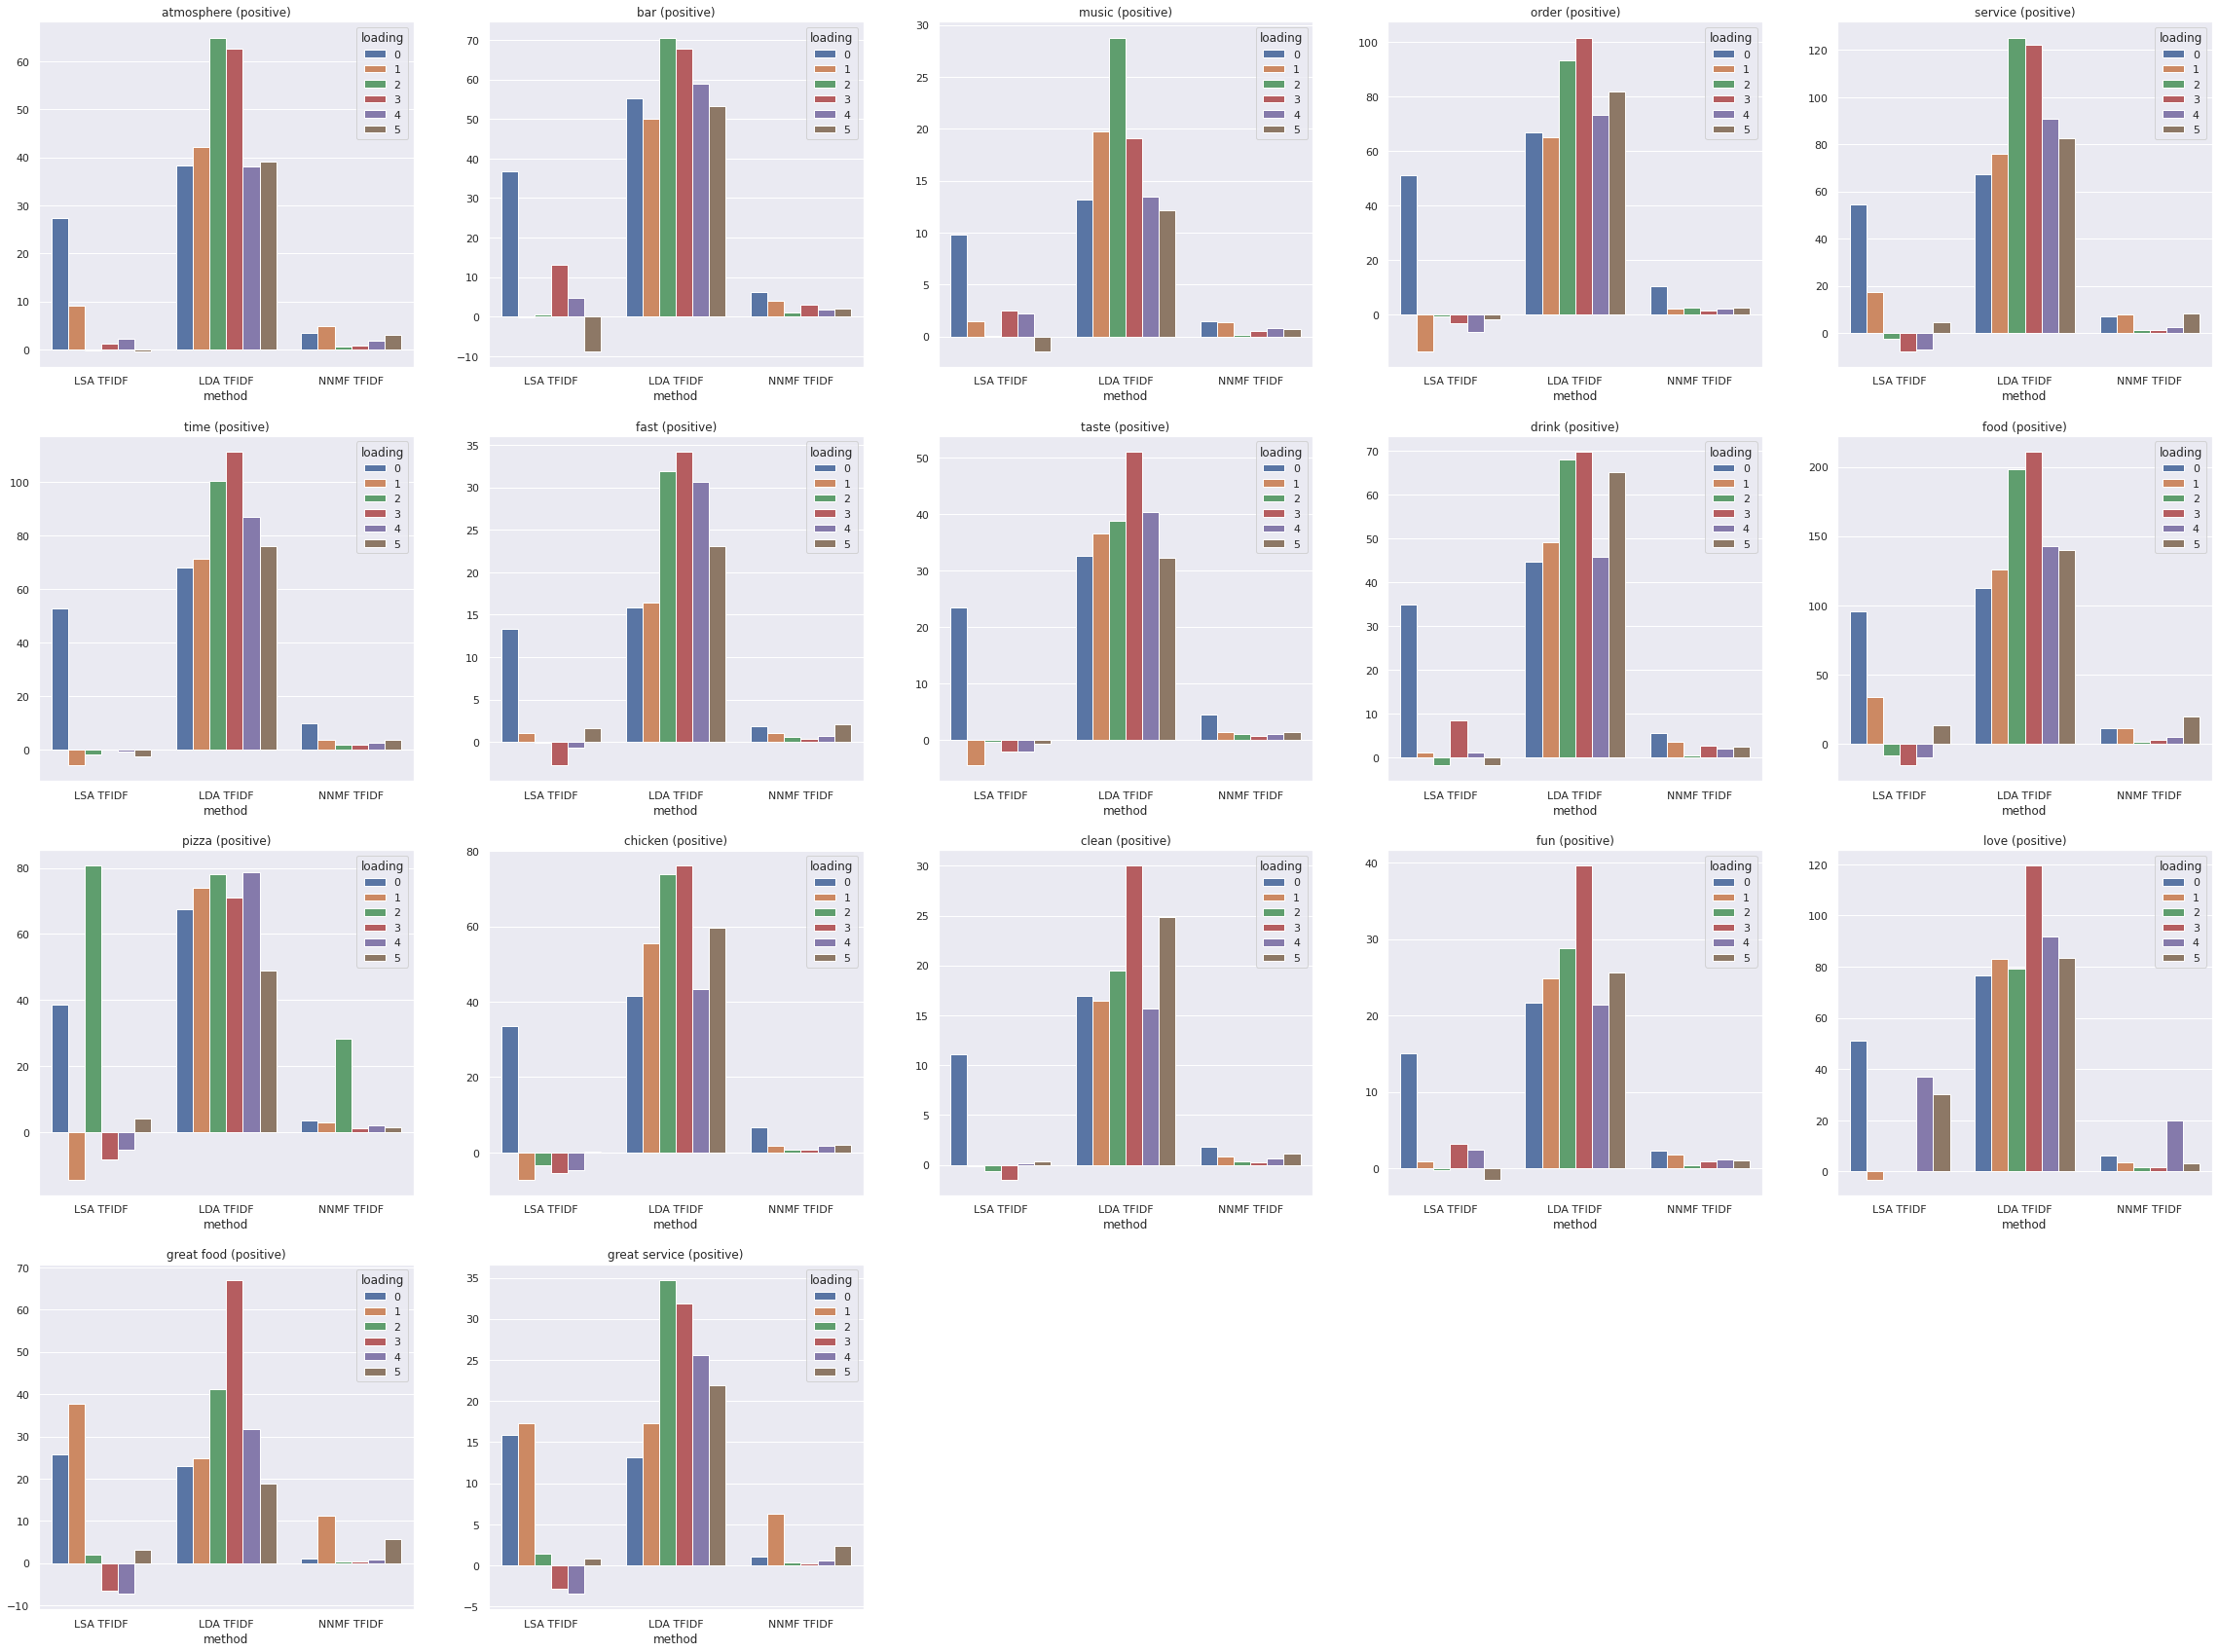

In [38]:
# The words to look at.
targetwords=['atmosphere', 'bar', 'music', 
             'order', 'service', 'time',
             'fast', 'taste', 'drink', 
             'food', 'pizza', 'chicken', 
             'clean', 'fun', 'love', 
             'great food', 'great service',
             ]


# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=comp_svd_pos.loc[word].append(
        comp_lda_pos.loc[word]).append(
            comp_nmf_pos.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method
labels = ['LSA TFIDF','LDA TFIDF','NNMF TFIDF']
wordloadings['method']=np.repeat(labels, ntopics, axis=0)
wordloadings['loading']=list(range(ntopics))*len(labels)

sns.set(style="darkgrid")
plt.figure(figsize=(40, 30))
for i, word in enumerate(targetwords):
    plt.subplot(4, 5, i+1) 
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word + ' (positive)')
    plt.ylabel("")

plt.show()

We are seeing similar behavior with LDA, LSA, and NNMF as we did with the negative reviews. We notice that the topics change a bit when compared to the negatives reviews. Using different target words and added bigrams since they seems to show up in top words. NNMF is the best extractor for the job. We will look more into the topics later in the notebook.


### NNMF BoW & Tf-idf

Both BoW and Tf-idf methods look very promising. They both isolate topics at a lot of key words. We will try to analyze and see what topics they extract. 





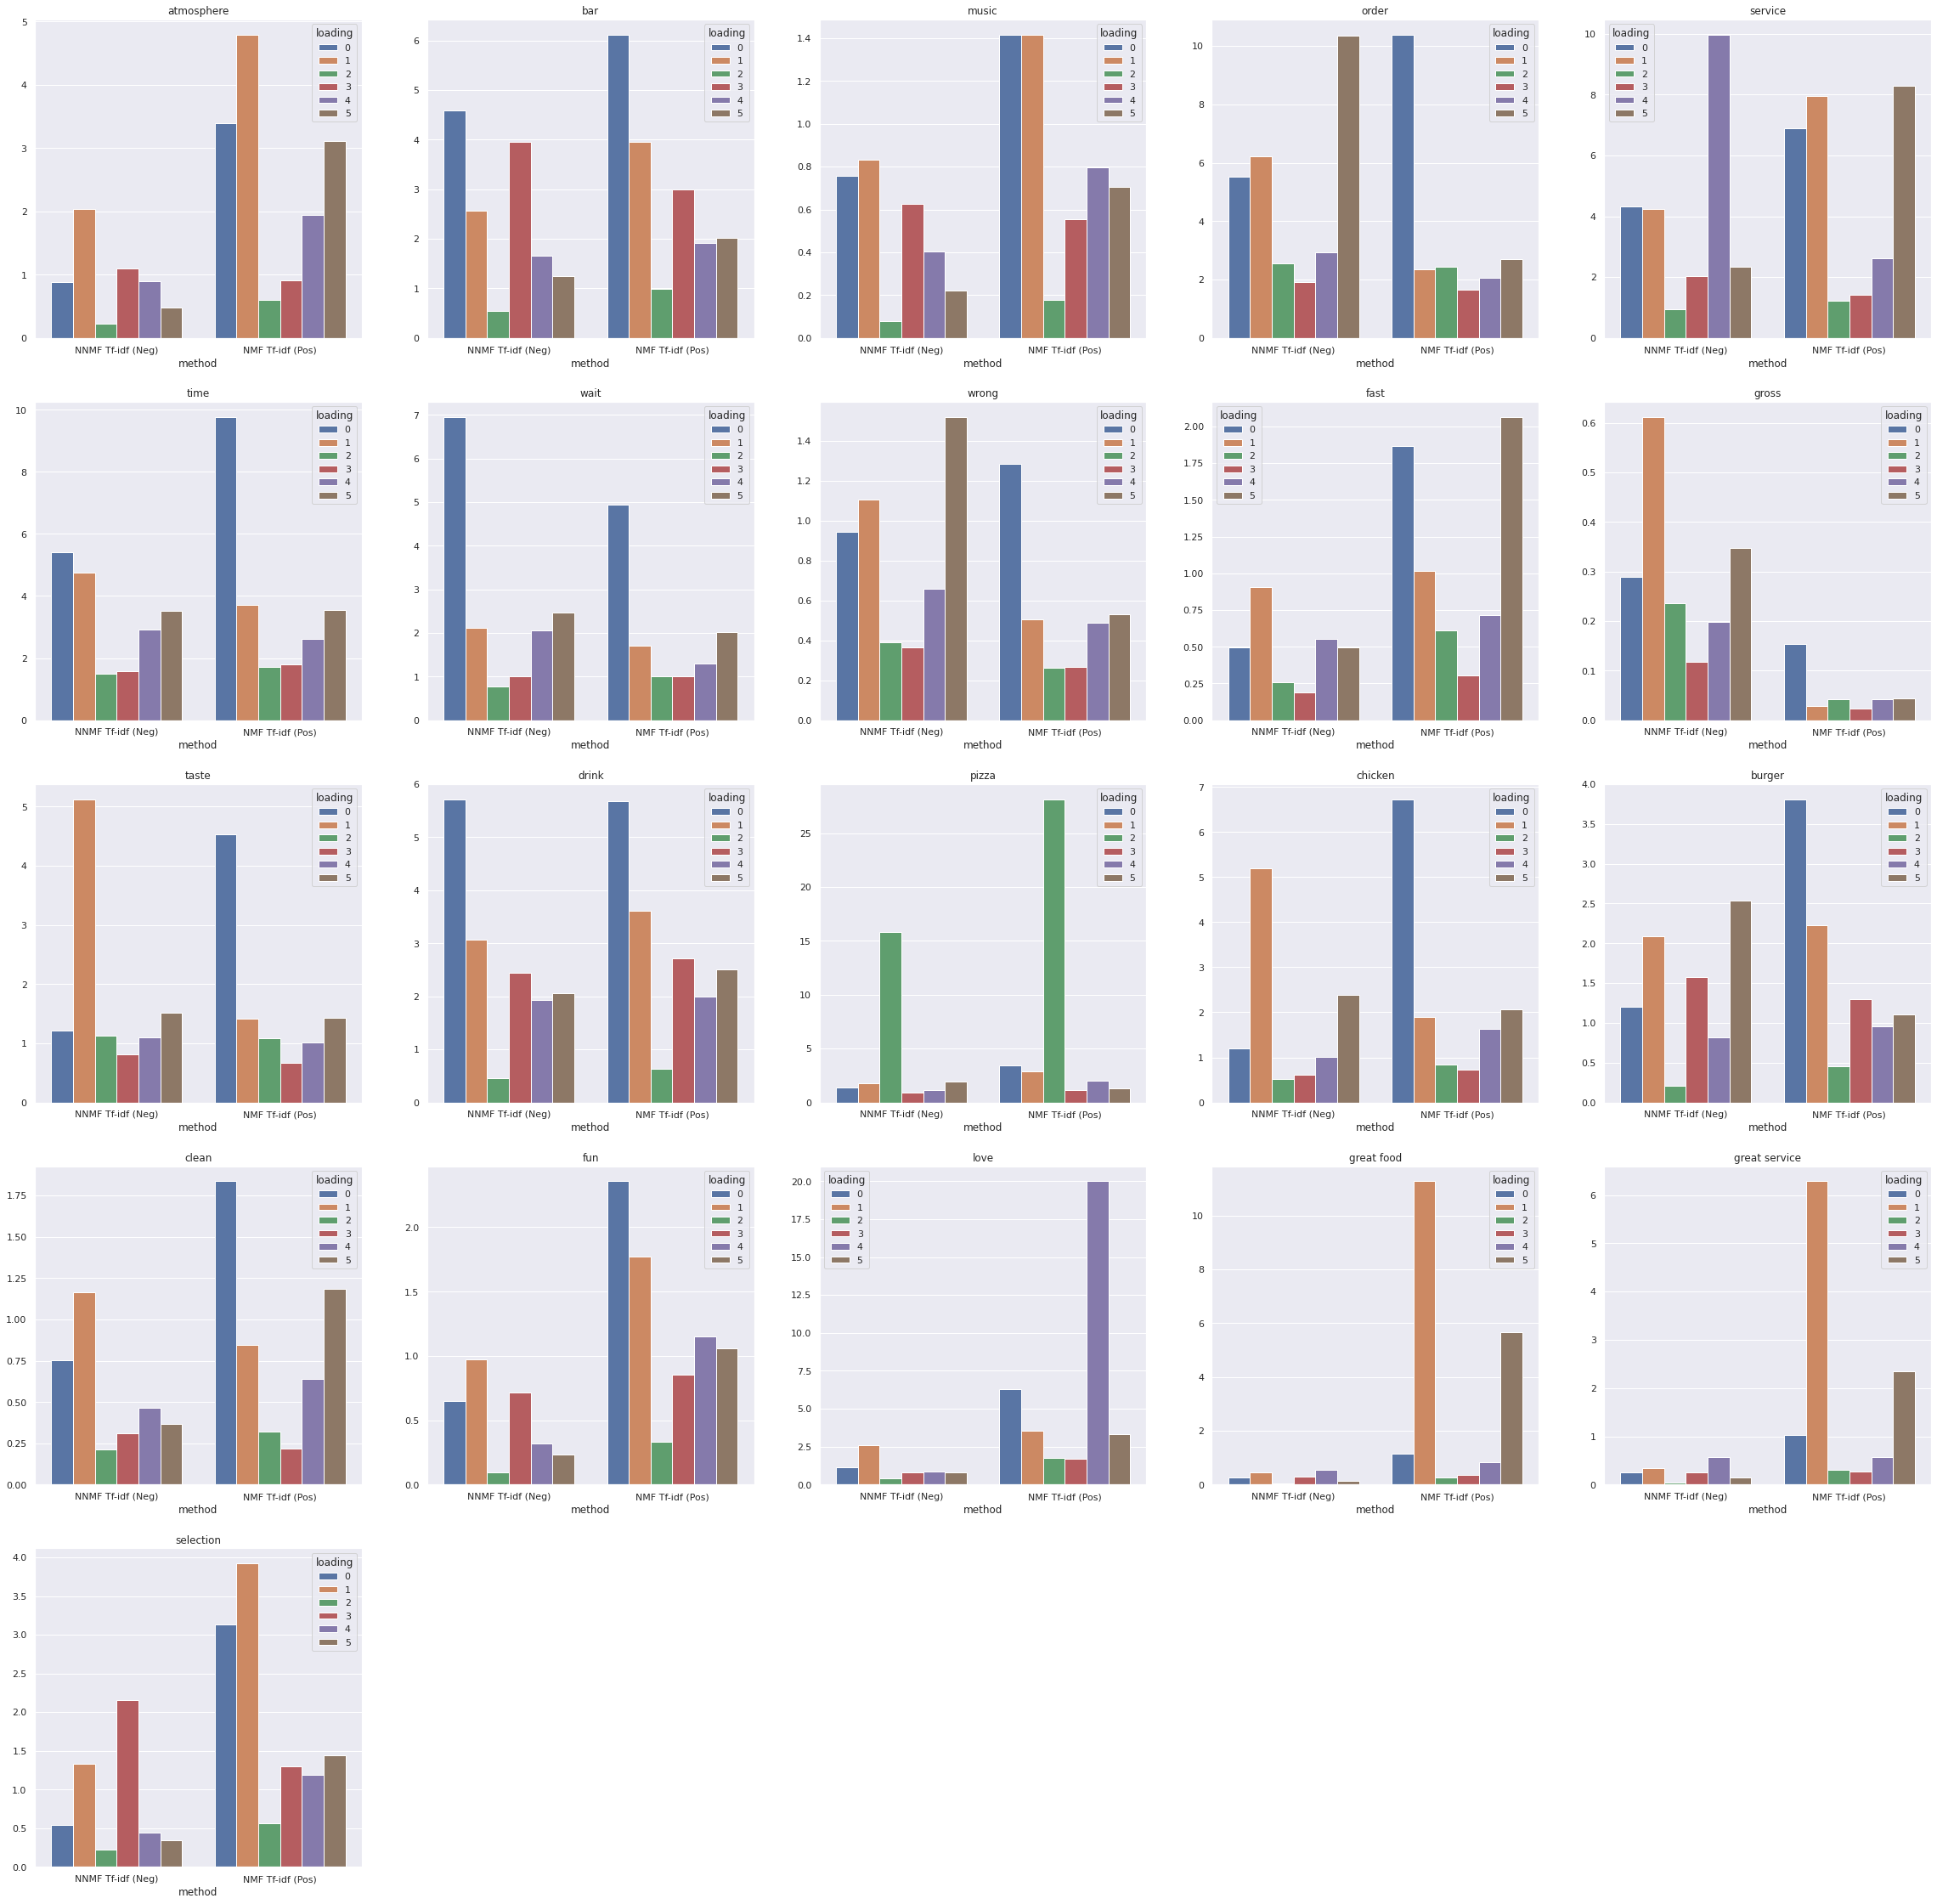

In [39]:
# The words to look at.
targetwords=['atmosphere', 'bar', 'music', 
             'order', 'service', 'time', 'wait', 'wrong', 
             'fast', 'gross', 'taste', 'drink', 'pizza', 
             'chicken', 'burger', 'clean', 'fun', 'love', 
             'great food', 'great service', 'selection'
             ]

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=comp_nmf_neg.loc[word].append(
        comp_nmf_pos.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method
labels = ['NNMF Tf-idf (Neg)','NMF Tf-idf (Pos)']
wordloadings['method']=np.repeat(labels, ntopics, axis=0)
wordloadings['loading']=list(range(ntopics))*len(labels)

sns.set(style="darkgrid")
plt.figure(figsize=(40, 40))
for i, word in enumerate(targetwords):
    plt.subplot(5, 5, i+1) 
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")

plt.show()

Using the graph above and the top words, we can see with the following topics with NNMF tf-idf:

NEGATIVE 
*   Topic 0: Bad bar service / drink orders take too long
*   Topic 1: Bad atmosphere / bad tasting food / bad chicken 
*   Topic 2: Pizza, cheese, crust, topping quality
*   Topic 3: Limited selection
*   Topic 4: Slow Service
*   Topic 5: Wrong orders and bad burgers


POSITIVE 
*   Topic 0: Good and timely bar service / good chicken and burgers / good music / clean
*   Topic 1: Great service / good atmosphere/ great food / good selection
*   Topic 2: Good pizza, cheese, crust, topping quality
*   Topic 3: Probably a dump topic (nightlife?)
*   Topic 4: People said they love this place.
*   Topic 5: Good food and fast service

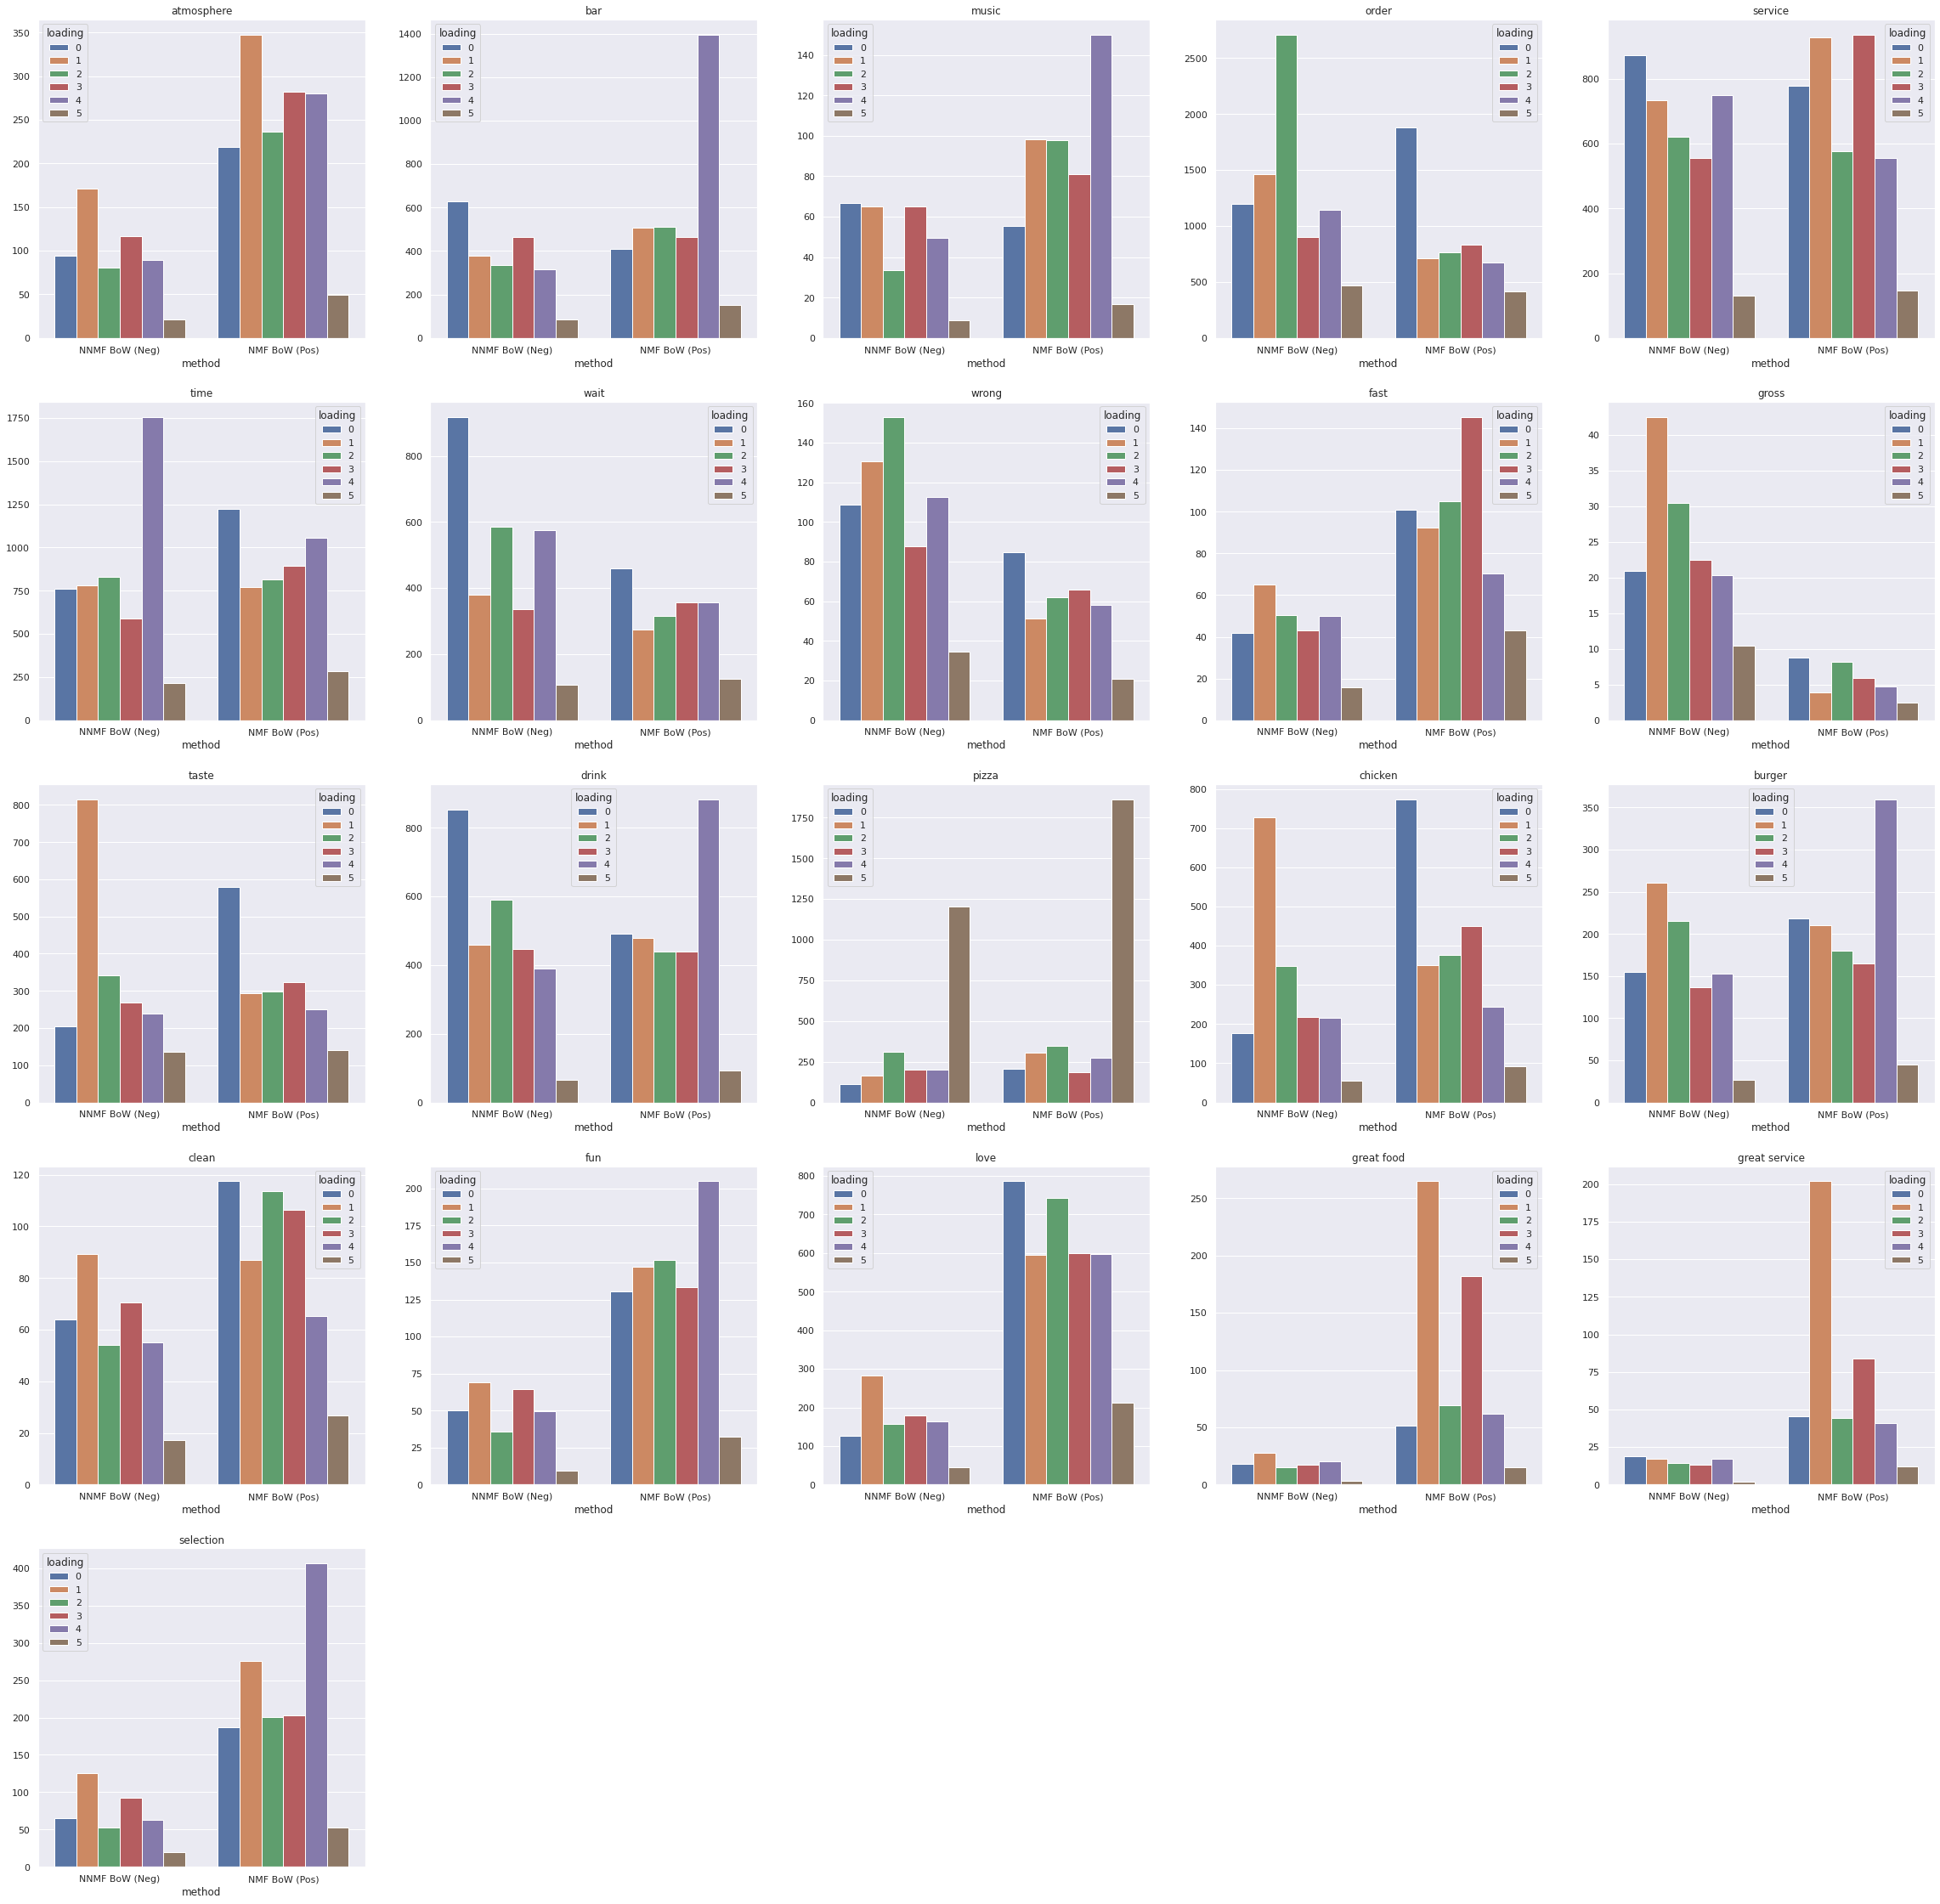

In [40]:
# The words to look at.
targetwords=['atmosphere', 'bar', 'music', 
             'order', 'service', 'time', 'wait', 'wrong', 
             'fast', 'gross', 'taste', 'drink', 'pizza', 
             'chicken', 'burger', 'clean', 'fun', 'love', 
             'great food', 'great service', 'selection'
             ]

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=comp_nmf_neg_bow.loc[word].append(
        comp_nmf_pos_bow.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method
labels = ['NNMF BoW (Neg)','NMF BoW (Pos)']
wordloadings['method']=np.repeat(labels, ntopics, axis=0)
wordloadings['loading']=list(range(ntopics))*len(labels)

sns.set(style="darkgrid")
plt.figure(figsize=(40, 40))
for i, word in enumerate(targetwords):
    plt.subplot(5, 5, i+1) 
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")

plt.show()

Using the graph above and the top words, we can see with the following topics with NNMF BoW:

NEGATIVE
*   Topic 0: Bad bar service / drink orders take too long
*   Topic 1: Bad atmosphere / bad tasting food / bad chicken / bad selection
*   Topic 2: Wrong orders
*   Topic 3: Probably a dump topic (Dirty restaurant?)
*   Topic 4: Slow Service
*   Topic 5: Pizza, cheese, crust, topping quality

POSITIVE 
*   Topic 0: Great chicken / the restaurant is clean
*   Topic 1: Great service / good atmosphere/ great food
*   Topic 2: People love this place. 
*   Topic 3: Fast delivery of food and fast service
*   Topic 4: Fun bar experience/ good music / good drinks / good burgers / good selection
*   Topic 5: Good pizza, cheese, crust, topping quality

There isn't much of a difference in the negative reviews betwen Tf-idf and BoW. We do see that 'selection' seems to isolate for tf-idf negative reviews. We do see that there are few notable differences when looking over the positive reviews. Bar experience (atmosphere and drinks) seems to be much more isolated and developed with BoW. Also, fast service has its own category with BoW. One noteable weakness of BoW is that the differences between the topics are less separated then they are with tf-idf. This could be due to the weighting that tf-idf provides.

Overall, we will use NNMF BoW for our final product.

# Phase 2 & 3 Conclusion

For phase 2, we were able to get a decent sentiment classifier, however we ran into an issue with reviews with no sentiment and reviews with mixed sentiment. To capture sentences with no sentiment, we could have filtered out reviews with prediction probabilities that were close to 0.5. We could have also found a way to weight longer reviews more heavily then shorter ones. In addition, we could have filtered out "neutral" words although this would be very hard to do. 

To handle reviews with mixed sentiment, we could have unraveled compound sentences and split them into multiple sentences. On the same note, if the reviews are multiple sentences long, we can simply split them by sentence. Both of these options are doable with the added features of the Spacy library.

For phase 3, we were able to get a good topic extractor using the NNMF BoW for the restaurants in Cleveland, Ohio. There are numerous ways that we can improve this model. When choosing the best extractor, we could have used more target words. In addition, we could have omitted or kept in certain stopwords during the vectorizing phase of the project. Adding the stopwords could add more noise, but it may also provide missing information. 

In addition, we could have expanded certain ngrams combinations for tf-idf and BoW. For tf-idf, we used single words, bigrams, and trigrams. We could have isolated each of these. 

For a very indepth analysis of the topics, we could have found best topics that were extracted from each of the models and then combine these topics into a single hybrid model.

